In [50]:
import pandas as pd
import quandl, math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing,svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import pickle # to save your trained classifier so that you don't need to re-train it again everytime

In [51]:
df = quandl.get('WIKI/GOOGL')

In [52]:
df.shape

(3424, 12)

In [53]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [54]:
df.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.0,1.0,1092.57,1108.70,1087.21,1094.00,1990515.0
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.0,1.0,1080.01,1083.92,1049.64,1053.15,3418154.0
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.0,1.0,1051.37,1066.78,1024.87,1026.55,2413517.0
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.0,1.0,1050.60,1059.27,1010.58,1054.09,3272409.0
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.0,1.0,1063.90,1064.54,997.62,1006.94,2940957.0


In [55]:
# Choosing only slected columns from
columns_chosen = ['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close','Adj. Volume']
df = df[columns_chosen]

In [56]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [57]:
# Adding some new columns
# HL_PCT  high minus low percent or volatility in stock price

df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low']

# This creates a new column that is the % spread based on the closing price, which is our crude measure of volatility.
# Next, we'll do daily percent change:

df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open']

In [58]:
df.tail()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,,,,
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.019766,0.001309
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.032659,-0.024870
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.040893,-0.023607
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.048180,0.003322
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.067080,-0.053539


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3424 entries, 2004-08-19 to 2018-03-27
Data columns (total 7 columns):
Adj. Open      3424 non-null float64
Adj. High      3424 non-null float64
Adj. Low       3424 non-null float64
Adj. Close     3424 non-null float64
Adj. Volume    3424 non-null float64
HL_PCT         3424 non-null float64
PCT_change     3424 non-null float64
dtypes: float64(7)
memory usage: 214.0 KB


In [60]:
math.ceil(len(df)*0.01)

35

In [61]:
forecast_column = 'Adj. Close'
# Replace NaN data with a high and invalid number which is -99999
df.fillna(value=-99999, inplace=True)
# We're saying we want to forecast out 1% of the entire length of the dataset into the future
forecast_out = int(math.ceil(len(df)*0.01))

In our case, we've decided the features are a bunch of the current values, and the label shall be the price, in the future, where the future is 1% of the entire length of the dataset out. We'll assume all current columns are our features, so we'll add a new column with a simple pandas operation:

In [62]:
# This will shift the column index up by the number of periods - here it is 1% of len(df) which rounded up is 35 and
# the column values it shifts up will be replaced with NaN

df['label'] = df[forecast_column].shift(-forecast_out)

In [63]:
# Lets create a copy of the dataframe so that we can run some tests on it
df1 = df.copy()

In [64]:
# Showing that the last 35 values have been shifted up and replaced with NaN values
df1.tail(36)

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,,,,
2018-02-05,1100.61,1114.99,1056.74,1068.76,3742469.0,0.055122,-0.028938,1006.94
2018-02-06,1033.98,1087.38,1030.01,1084.43,3732527.0,0.055698,0.048792,NaN
2018-02-07,1084.97,1086.53,1054.62,1055.41,2544683.0,0.030257,-0.027245,NaN
2018-02-08,1059.87,1063.93,1005.12,1005.60,3067173.0,0.058510,-0.051204,NaN
2018-02-09,1025.88,1051.72,997.00,1043.43,4436032.0,0.054885,0.017107,NaN
2018-02-12,1056.67,1065.57,1045.49,1054.56,2796258.0,0.019206,-0.001997,NaN
2018-02-13,1050.00,1061.22,1046.92,1054.14,1574121.0,0.013659,0.003943,NaN
2018-02-14,1054.32,1075.47,1049.80,1072.70,2029979.0,0.024452,0.017433,NaN
2018-02-15,1083.45,1094.10,1067.23,1091.36,1806206.0,0.025177,0.007301,NaN


In [65]:
# Drop any NaN values if it still exists
# Now drop the NaN values, this will remove the last 35 columns from our data
df1.dropna(inplace=True)

It is a typical standard with machine learning in code to define X (capital x), as the features, and y (lowercase y) as the label that corresponds to the features. As such, we can define our features and labels like so:

In [66]:
# Demonstrating that the rows with NaN have been removed and the last row as seen is the row just above the last NaN value
# Ths would work is we did df.dropna in the previous step, but thats not what we are going to do now
df1.tail(5)

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,,,,
2018-01-30,1177.72,1187.93,1174.51,1177.37,1792602.0,0.011426,-0.000297,1094.00
2018-01-31,1183.81,1186.32,1172.10,1182.22,1643877.0,0.012132,-0.001343,1053.15
2018-02-01,1175.99,1187.45,1169.36,1181.59,2774967.0,0.015470,0.004762,1026.55
2018-02-02,1127.42,1131.30,1111.17,1119.20,5798880.0,0.018116,-0.007291,1054.09
2018-02-05,1100.61,1114.99,1056.74,1068.76,3742469.0,0.055122,-0.028938,1006.94


In [67]:
# All columns except for 'label' will be considered as features
X = np.array(df1.drop(['label'], axis=1))
y = np.array(df1['label'])

In [68]:
print("Length of X is - ", len(X))
print("Length of y is -", len(y))

Length of X is -  3389
Length of y is - 3389


We could leave it at this, and move on to training and testing, but we're going to do some pre-processing. Generally, you want your features in machine learning to be in a range of -1 to 1. This may do nothing, but it usually speeds up processing and can also help with accuracy. Because this range is so popularly used, it is included in the preprocessing module of Scikit-Learn. To utilize this, you can apply preprocessing.scale to your X variable:

In [69]:
# apply preprocessing.scale to your X variable
X = preprocessing.scale(X)
# y has already been created, which is the label

In [70]:
# Now comes the training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# Let's use the Support Vector Regression from Scikit Learn  svm package
clf = svm.SVR()
# using the defaults only

In [72]:
# fit the model
clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [73]:
# Our classifier is now trained. Wow that was easy. Now we can test it!
confidence  = clf.score(X_test, y_test)
print("Confidence our SVR classifier is: ", confidence)

Confidence our SVR classifier is:  0.802658260978


In [74]:
# Now lets try with Linear Regression
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence  = clf.score(X_test, y_test)
print("Confidence our Linear Regression classifier is: ", confidence)

Confidence our Linear Regression classifier is:  0.977982745153


In [75]:
# Next up, let's check out the LinearRegression algorithm. Do you see n_jobs here? Indeed!
# So here, you can specify exactly how many threads you'll want. 
#If you put in -1 for the value, then the algorithm will use all available threads.
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence  = clf.score(X_test, y_test)
print("Confidence our Linear Regression classifier is: ", confidence)

Confidence our Linear Regression classifier is:  0.977982745153


In [76]:
# Trying the different kernels for SVR
# In the case of svm.SVR, the default is rbf, which is a type of kernel. You have a few other choices though. 
# Check the documentation, you have 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable

for k in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = svm.SVR(kernel = k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print("Confidence for kernel - ", k, "is ", confidence)

Confidence for kernel -  linear is  0.97747100844
Confidence for kernel -  poly is  0.65470292788
Confidence for kernel -  rbf is  0.802658260978
Confidence for kernel -  sigmoid is  0.772035206656


In [77]:
# Now that we have performed some test, lets go back to our intital dataframe which is df
df.shape
df.tail()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,,,,
2018-03-21,1092.57,1108.70,1087.21,1094.00,1990515.0,0.019766,0.001309,NaN
2018-03-22,1080.01,1083.92,1049.64,1053.15,3418154.0,0.032659,-0.024870,NaN
2018-03-23,1051.37,1066.78,1024.87,1026.55,2413517.0,0.040893,-0.023607,NaN
2018-03-26,1050.60,1059.27,1010.58,1054.09,3272409.0,0.048180,0.003322,NaN
2018-03-27,1063.90,1064.54,997.62,1006.94,2940957.0,0.067080,-0.053539,NaN


In [78]:
X = np.array(df.drop(['label'], axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:] # which we will use to predict
X = X[:-forecast_out] # the actual X for which the labels are the forecasted stock price 35 days into the future for every single row
# Drop the NaN values in the labels, which have been created as result of shifting the values up
df.dropna(inplace=True)
print("Length of X:", len(X))
print("Length of y:", len(y))
len(y)
#df.tail(50)

Length of X: 3389
Length of y: 3389


3389

In [79]:
# the features of which will be used to predict for the last 1% of the total population
# Here it will be X[-35:] # last 35 samples to predict labels for
# the NaN values in the labels have been removed and now we can use it to train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
# clf = LinearRegression(n_jobs=-1)
# clf.fit(X_train, y_train)
# confidence  = clf.score(X_test, y_test)
# print("Confidence our Linear Regression classifier is: ", confidence)

In [80]:
# Saving the trained classifier into a file
# for that import pickle

# with open('linearregression.pickle', 'wb') as f:
#     pickle.dump(clf, f)

In [81]:
# To use the saved classifier
# The above 2 cells can be commeneted once the classsifier has been trained and saved to a file
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

In [82]:
# Predict stock prices
forecast_set = clf.predict(X_lately)
len(forecast_set)

35

In [83]:
# forecast_set is the set of predictions for the labels for the last 1%
# forecast_set has the predictions for 35 days into the future starting from the last 35th row in the dataframe till the last
print(forecast_set, confidence, forecast_out)

[ 1075.22718688  1072.83036679  1016.57383271  1030.70608112  1071.29942187
  1074.73361068  1082.9942      1097.50495561  1119.40164435  1121.48246504
  1137.29607266  1130.10854276  1139.48257893  1160.88461722  1136.910521
  1125.09125185  1083.90226272  1086.52633241  1105.67060688  1121.22266457
  1125.09618565  1148.61498238  1169.6317723   1187.7874692   1154.44369156
  1171.29476883  1164.77587058  1153.0131757   1111.18712716  1108.917723
  1115.1498419   1068.50309818  1044.90819758  1039.89658063  1008.85304793] 0.772035206656 35


# Visualize

In [84]:
import datetime
from matplotlib import style

In [85]:
# Lets set a style
style.use('ggplot')

In [86]:
# Lets add a new column to the dataframe
df['Forecast'] = np.nan

In [87]:
df.tail(50)

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,,,,
2017-11-22,1051.16,1055.43,1047.25,1051.92,721498.0,0.007811,0.000723,1130.70,NaN
2017-11-24,1054.39,1060.07,1051.92,1056.52,825342.0,0.007748,0.002020,1139.10,NaN
2017-11-27,1058.57,1073.04,1054.77,1072.01,1708195.0,0.017321,0.012696,1135.97,NaN
2017-11-28,1073.99,1080.00,1054.54,1063.29,1694098.0,0.024143,-0.009963,1143.50,NaN
2017-11-29,1056.18,1058.77,1029.65,1037.38,2737664.0,0.028281,-0.017800,1164.16,NaN
2017-11-30,1039.94,1044.14,1030.07,1036.17,2190379.0,0.013659,-0.003625,1176.17,NaN
2017-12-01,1030.41,1037.24,1016.90,1025.07,1850541.0,0.020002,-0.005182,1171.29,NaN
2017-12-04,1027.80,1031.34,1009.22,1011.87,1896325.0,0.021918,-0.015499,1182.14,NaN
2017-12-05,1010.99,1036.68,1002.32,1019.60,1927802.0,0.034280,0.008516,1187.56,NaN


In [88]:
df.iloc[-1].name

Timestamp('2018-02-05 00:00:00')

In [89]:
df.tail(1).index

DatetimeIndex(['2018-02-05'], dtype='datetime64[ns]', name='Date', freq=None)

In [90]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
next_unix

1517846400.0

In [91]:
# Adding the predicted values to 'Forecast' column of the dataframe and converting all other features for the
# predicted dates to be NaN.
# Here we are getting the actual dates for the predicted stock prices and the actual dates are the 

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

In [92]:
df.index[-5:]

DatetimeIndex(['2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11',
               '2018-03-12'],
              dtype='datetime64[ns]', name='Date', freq=None)

# Plot

In [93]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,0.084410,0.003250,69.078238,NaN
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,0.085373,0.072270,67.839414,NaN
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,0.040624,-0.012279,68.912727,NaN
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,0.077532,-0.057264,70.668146,NaN
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,0.039661,0.011837,71.219849,NaN


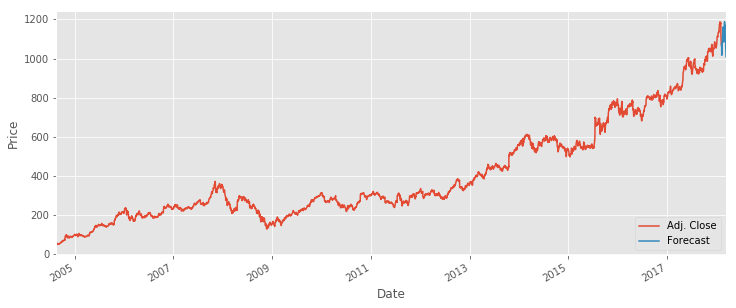

In [94]:
df['Adj. Close'].plot(figsize = (12,5))
df['Forecast'].plot(figsize = (12,5))
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc=4)
plt.show();

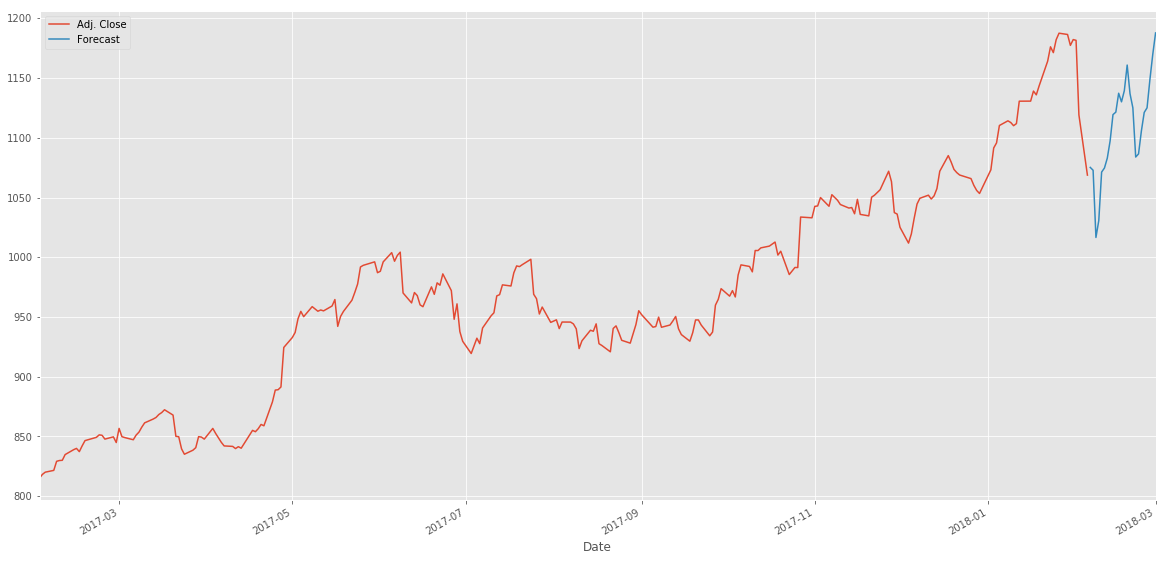

In [95]:
# Mentioning the dat range also
df.loc['2017-02-01': '2018-03-01',['Adj. Close', 'Forecast']].plot(figsize=(20,10))